In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import root_mean_squared_error as rmse
import graphviz
import re
import dtreeviz

In [2]:
df = pd.read_csv('../data/TrainAndValid.csv', parse_dates=['saledate'], low_memory=False)
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

In [4]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

Trước tiên, chúng ta cần xử lý các cột thứ tự (ordinal columns). Đó là những cột chứa chuỗi nhưng có một thứ tự tự nhiên, ví dụ như nhỏ, trung bình và lớn.

In [5]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large',
       'Compact'], dtype=object)

In [6]:
df['UsageBand'].unique()

array(['Low', 'High', 'Medium', nan], dtype=object)

In [7]:
df['Hydraulics_Flow'].unique()

array([nan, 'Standard', 'High Flow', 'None or Unspecified'], dtype=object)

In [8]:
df['Engine_Horsepower'].unique()

array([nan, 'No', 'Variable'], dtype=object)

khá là bất ngờ là cột này không chứa giá trị công suất thực tế, cứ để nguyên cột này như vậy

In [9]:
df['Undercarriage_Pad_Width'].unique()

array([nan, 'None or Unspecified', '16 inch', '32 inch', '28 inch',
       '30 inch', '22 inch', '24 inch', '18 inch', '36 inch', '20 inch',
       '27 inch', '15 inch', '26 inch', '34 inch', '33 inch', '14 inch',
       '31 inch', '25 inch', '31.5 inch'], dtype=object)

`Undercarriage_Pad_Width` chứa các giá trị đo dạng số, có thể trích xuất ra các số và chuyển thành kiểu số.

In [10]:
df['Blade_Width'].unique()

array([nan, 'None or Unspecified', "12'", "14'", "13'", "16'", "<12'"],
      dtype=object)

`Blade_Width` cũng chứa các giá trị đo dạng số và có thể trích xuất, nhưng cần xử lý thêm trường hợp đặc biệt "<12".

In [11]:
df['Stick_Length'].unique()

array([nan, 'None or Unspecified', '11\' 0"', '15\' 9"', '10\' 2"',
       '10\' 6"', '9\' 10"', '10\' 10"', '9\' 6"', '9\' 7"', '12\' 8"',
       '8\' 2"', '8\' 6"', '9\' 8"', '12\' 10"', '11\' 10"', '8\' 10"',
       '8\' 4"', '12\' 4"', '9\' 5"', '6\' 3"', '14\' 1"', '13\' 7"',
       '13\' 10"', '13\' 9"', '7\' 10"', '15\' 4"', '9\' 2"', '24\' 3"',
       '19\' 8"'], dtype=object)

`Stick_Length` có các đơn vị đo là feet và inches

In [12]:
df['Tire_Size'].unique()

array(['None or Unspecified', '23.5', nan, '13"', '26.5', '29.5', '14"',
       '20.5', '17.5"', '15.5"', '20.5"', '17.5', '7.0"', '15.5', '23.5"',
       '10"', '23.1"', '10 inch'], dtype=object)

Cột `Tire_size` khá lộn xộn, có lẽ là do bộ dữ liệu này được gộp từ nhiều nguồn.

In [13]:
df['Undercarriage_Pad_Width'].value_counts(dropna=False)

Undercarriage_Pad_Width
NaN                    309782
None or Unspecified     82444
32 inch                  5287
28 inch                  3152
24 inch                  2998
20 inch                  2664
30 inch                  1602
36 inch                  1544
18 inch                  1439
34 inch                   540
16 inch                   481
31 inch                   191
27 inch                   144
22 inch                   135
26 inch                    98
33 inch                    94
14 inch                    51
15 inch                    33
25 inch                    17
31.5 inch                   2
Name: count, dtype: int64

In [14]:
df['Stick_Length'].value_counts(dropna=False)

Stick_Length
NaN                    310437
None or Unspecified     81539
9' 6"                    5832
10' 6"                   3519
11' 0"                   1601
9' 10"                   1463
9' 8"                    1462
9' 7"                    1423
12' 10"                  1087
10' 2"                   1004
8' 6"                     908
8' 2"                     614
10' 10"                   414
12' 8"                    322
11' 10"                   307
8' 4"                     274
8' 10"                    104
12' 4"                    103
9' 5"                     101
15' 9"                     87
6' 3"                      51
13' 7"                     11
14' 1"                      7
13' 10"                     7
13' 9"                      7
19' 8"                      5
7' 10"                      3
15' 4"                      3
24' 3"                      2
9' 2"                       1
Name: count, dtype: int64

In [15]:
size_order = ['Mini', 'Compact', 'Small', 'Medium', 'Large / Medium', 'Large']
df['ProductSize'] = pd.Categorical(df['ProductSize'], categories=size_order, ordered=True)
df['ProductSize'].head(5)

0       NaN
1    Medium
2       NaN
3     Small
4       NaN
Name: ProductSize, dtype: category
Categories (6, object): ['Mini' < 'Compact' < 'Small' < 'Medium' < 'Large / Medium' < 'Large']

In [16]:
usage_order = ['Low', 'Medium', 'High']
df['UsageBand'] = pd.Categorical(df['UsageBand'], categories=usage_order, ordered=True)

In [17]:
flow_order = ['None or Unspecified', 'Standard', 'High Flow']
df['Hydraulics_Flow'] = pd.Categorical(df['Hydraulics_Flow'], categories=flow_order, ordered=True)
df['Hydraulics_Flow'].head(5)

0         NaN
1         NaN
2    Standard
3         NaN
4    Standard
Name: Hydraulics_Flow, dtype: category
Categories (3, object): ['None or Unspecified' < 'Standard' < 'High Flow']

In [18]:
def extract_pad_width(x):
    if pd.isna(x) or x == 'None or Unspecified': return np.nan
    return float(x.split(' ')[0])

In [19]:
df['Undercarriage_Pad_Width_num'] = df['Undercarriage_Pad_Width'].apply(extract_pad_width)

In [20]:
def extract_blade_width(x):
    if pd.isna(x) or x == 'None or Unspecified': return np.nan
    if x == "<12'": return 11.0 # assign a value just blow 12 in this case
    return float(x.replace("'", ""))

In [21]:
df['Blade_Width_num'] = df['Blade_Width'].apply(extract_blade_width)

In [22]:
def extract_stick_length(x):
    if pd.isna(x) or x == 'None or Unspecified': return np.nan
    parts = x.replace('"', '').split("' ")
    feet = float(parts[0])
    inches = float(parts[1]) if len(parts) > 1 else 0
    return feet * 12 + inches # convert to total inches

In [23]:
df['Stick_Length_inches'] = df['Stick_Length'].apply(extract_stick_length)

In [24]:
def extract_tire_size(x):
    if pd.isna(x) or x == 'None or Unspecified': return np.nan
    if 'inch' in x: return float(x.split(' ')[0])
    return float(x.replace('"', ''))

In [25]:
df['Tire_Size_num'] = df['Tire_Size'].apply(extract_tire_size)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   SalesID                      412698 non-null  int64         
 1   SalePrice                    412698 non-null  float64       
 2   MachineID                    412698 non-null  int64         
 3   ModelID                      412698 non-null  int64         
 4   datasource                   412698 non-null  int64         
 5   auctioneerID                 392562 non-null  float64       
 6   YearMade                     412698 non-null  int64         
 7   MachineHoursCurrentMeter     147504 non-null  float64       
 8   UsageBand                    73670 non-null   category      
 9   saledate                     412698 non-null  datetime64[ns]
 10  fiModelDesc                  412698 non-null  object        
 11  fiBaseModel               

In [27]:
idx = df['YearMade'] > df['saledate'].dt.year
df[idx]

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,Undercarriage_Pad_Width_num,Blade_Width_num,Stick_Length_inches,Tire_Size_num
27786,1256766,27000.0,1424836,3247,132,2.0,1997,NaN,NaN,1996-12-13,...,Double,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81843,1380049,29000.0,1189094,3538,132,1.0,2000,NaN,NaN,1999-10-14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
161311,1582210,60000.0,1482307,28842,132,1.0,2006,NaN,NaN,2005-02-15,...,Double,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176543,1607397,72000.0,1104056,4753,132,11.0,1998,NaN,NaN,1997-05-29,...,NaN,NaN,NaN,NaN,Standard,Conventional,NaN,NaN,NaN,NaN
206920,1656135,26500.0,1229496,8559,132,1.0,1998,NaN,NaN,1996-02-21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN
209191,1662009,8500.0,1481256,14755,132,2.0,2008,NaN,NaN,2001-10-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213253,1672382,12000.0,1151751,4988,132,4.0,2008,NaN,NaN,1996-02-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231762,1725834,22500.0,1106818,8954,132,1.0,2006,NaN,NaN,1996-07-16,...,Double,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242681,1748962,27000.0,1361981,257,132,6.0,2008,NaN,NaN,1997-12-15,...,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN
251546,1766755,100000.0,1241578,457,132,6.0,2002,NaN,NaN,1995-08-11,...,Double,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126.0,NaN


Như đã thảo luận trong notebook EDA, chúng ta sẽ điền giá trị này bằng cùng ngày thuộc năm của trường `saledate`.

In [28]:
df.loc[idx, 'YearMade'] = df.loc[idx, 'saledate'].dt.year

In [29]:
df['YearMade'].unique().min()

np.int64(1000)

tương tự với `YearMade` = 1000 nó là giá trị mặc định cho giá trị khuyết như đã thảo luận ở EDA notebook, chúng ta sẽ điền nó với 1950

In [30]:
df.loc[df['YearMade'] < 1900, 'YearMade'] = 1950

### handling date

vì chúng ta sẽ sử dụng mô hình dựa trên cây, về cơ bản nó sẽ chia nhóm thành hai phần, nên khi xử lý kiểu dữ liệu ngày tháng, chúng ta nên coi nó giống như kiểu dữ liệu thứ tự (ordinal), vì ngày tháng cũng có thứ tự tự nhiên (một ngày lớn hơn ngày khác). Tuy nhiên, ngày tháng có một điểm khác biệt vì một số ngày có thể liên quan đến các sự kiện đặc biệt, điều này có thể ảnh hưởng đáng kể đến giá bán, chẳng hạn như ngày đó có chương trình giảm giá, là ngày lễ, hoặc trùng với các sự kiện lớn hay chương trình khuyến mãi. Vì vậy, chúng ta muốn mô hình của mình hiểu nhiều hơn là chỉ biết một ngày gần đây hơn hay xa hơn ngày khác

In [31]:
df['saleYear'] = df['saledate'].dt.year
df['saleMonth'] = df['saledate'].dt.month
df['saleDay'] = df['saledate'].dt.day
df['saleWeek'] = df['saledate'].dt.isocalendar().week
df['saleDayofweek'] = df['saledate'].dt.dayofweek
df['saleDayofyear'] = df['saledate'].dt.dayofyear

In [32]:
df['saleIs_month_end'] = df['saledate'].dt.is_month_end.astype(int)
df['saleIs_month_start'] = df['saledate'].dt.is_month_start.astype(int)
df['saleIs_quarter_end'] = df['saledate'].dt.is_quarter_end.astype(int)
df['saleIs_quarter_start'] = df['saledate'].dt.is_quarter_start.astype(int)
df['saleIs_year_end'] = df['saledate'].dt.is_year_end.astype(int)
df['saleIs_year_start'] = df['saledate'].dt.is_year_start.astype(int)

In [33]:
min_date = df['saledate'].min()
df['saleElapsed'] = (df['saledate'] - min_date).dt.days

In [34]:
date_cols = [col for col in df.columns if col.startswith('sale') and col != 'saledate' and col != 'saleprice']
df[date_cols].head()

,saleYear,saleMonth,saleDay,saleWeek,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,2006,11,16,46,3,320,0,0,0,0,0,0,6512
1,2004,3,26,13,4,86,0,0,0,0,0,0,5547
2,2004,2,26,9,3,57,0,0,0,0,0,0,5518
3,2011,5,19,20,3,139,0,0,0,0,0,0,8157
4,2009,7,23,30,3,204,0,0,0,0,0,0,7492


In [35]:
df.drop('saledate', axis=1, inplace=True)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 69 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   SalesID                      412698 non-null  int64   
 1   SalePrice                    412698 non-null  float64 
 2   MachineID                    412698 non-null  int64   
 3   ModelID                      412698 non-null  int64   
 4   datasource                   412698 non-null  int64   
 5   auctioneerID                 392562 non-null  float64 
 6   YearMade                     412698 non-null  int64   
 7   MachineHoursCurrentMeter     147504 non-null  float64 
 8   UsageBand                    73670 non-null   category
 9   fiModelDesc                  412698 non-null  object  
 10  fiBaseModel                  412698 non-null  object  
 11  fiSecondaryDesc              271971 non-null  object  
 12  fiModelSeries                58667 non-null 

In [37]:
num_mis = []
for label, content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isna(content).sum(): num_mis.append(label)
num_mis

['auctioneerID',
 'MachineHoursCurrentMeter',
 'Undercarriage_Pad_Width_num',
 'Blade_Width_num',
 'Stick_Length_inches',
 'Tire_Size_num']

In [38]:
df[num_mis].isna().sum()

auctioneerID                    20136
MachineHoursCurrentMeter       265194
Undercarriage_Pad_Width_num    392226
Blade_Width_num                396236
Stick_Length_inches            391976
Tire_Size_num                  362883
dtype: int64

một số cột có hơn 90% giá trị bị thiếu, khi xử lý với dữ liệu bị thiếu nhiều như vậy, mình thường thêm một cột mới has_{col} và điền giá trị thiếu bằng -1, vì mô hình dựa trên cây có thể dễ dàng tạo một nhánh phân chia giữa giá trị -1 và các giá trị thực tế.

In [39]:
sparse_num_cols = ['auctioneerID','Undercarriage_Pad_Width_num', 'Blade_Width_num', 
                   'Stick_Length_inches', 'Tire_Size_num']
for col in sparse_num_cols:
    df[f'has_{col}'] = (~df[col].isna()).astype(int)
    df[col] = df[col].fillna(-1)

In [40]:
# use group-specific medians for machine hours
median_hours_by_group = df.groupby(['ProductGroup', 'YearMade'])['MachineHoursCurrentMeter'].transform('median')
df['MachineHoursCurrentMeter'] = df['MachineHoursCurrentMeter'].fillna(median_hours_by_group)

drop redundant columns

In [41]:
original_cols_to_drop = ['Stick_Length', 'Undercarriage_Pad_Width', 'Blade_Width', 'Tire_Size']
df.drop(original_cols_to_drop, axis=1, inplace=True)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 70 columns):
 #   Column                           Non-Null Count   Dtype   
---  ------                           --------------   -----   
 0   SalesID                          412698 non-null  int64   
 1   SalePrice                        412698 non-null  float64 
 2   MachineID                        412698 non-null  int64   
 3   ModelID                          412698 non-null  int64   
 4   datasource                       412698 non-null  int64   
 5   auctioneerID                     412698 non-null  float64 
 6   YearMade                         412698 non-null  int64   
 7   MachineHoursCurrentMeter         412449 non-null  float64 
 8   UsageBand                        73670 non-null   category
 9   fiModelDesc                      412698 non-null  object  
 10  fiBaseModel                      412698 non-null  object  
 11  fiSecondaryDesc                  271971 non-null  ob

In [43]:
obj_cols = df.select_dtypes(include=['object']).columns.to_list()
for col in obj_cols:
    df[col] = pd.Categorical(df[col])

In [44]:
cat_cols  = df.select_dtypes(include=['category']).columns.to_list()
for col in cat_cols:
    df[f'has_{col}'] = (~df[col].isna()).astype('int8')
    df[col] = df[col].cat.codes + 1

/tmp/ipykernel_95985/2999767454.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_95985/2999767454.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 110 entries, SalesID to has_Steering_Controls
dtypes: UInt32(1), float64(7), int16(4), int32(5), int64(17), int8(76)
memory usage: 118.5 MB


In [46]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])


Khi làm việc với dữ liệu chuỗi thời gian, chúng ta cần chú ý khi chia dữ liệu thành tập huấn luyện và tập kiểm tra, vì thường ta muốn dự đoán dữ liệu trong tương lai, nên tập kiểm tra (validation) nên nằm ở thời điểm sau tập huấn luyện.

Trong wiki của cuộc thi có nói rằng tập kiểm tra (test set) sẽ là từ tháng 5 đến tháng 11 năm 2012, trong khi dữ liệu huấn luyện và kiểm tra của chúng ta kết thúc vào ngày 30 tháng 4 năm 2012. Vì vậy, chúng ta nên chọn tập kiểm tra (validation) có cùng khoảng thời gian 6 tháng như tập test, tức là từ tháng 11 năm 2011 đến ngày 30 tháng 4 năm 2012, và tập huấn luyện sẽ là dữ liệu từ trước tháng 11 năm 2011.

In [47]:
df['saleYear'].min(), df['saleYear'].max()

(np.int32(1989), np.int32(2012))

In [48]:
cond = (df.saleYear < 2011) | ((df.saleYear == 2011) & (df.saleMonth<=10))
trn_idx = np.where(cond)[0]
val_idx = np.where(~cond)[0]

trn_data, val_data = df.iloc[trn_idx], df.iloc[val_idx]

In [49]:
trn_data.shape, val_data.shape

((395371, 110), (17327, 110))

In [50]:
Xs, y = trn_data.drop(dep_var, axis=1), trn_data[dep_var]
val_Xs, val_y = val_data.drop(dep_var, axis=1), val_data[dep_var]

In [51]:
Xs.shape, y.shape

((395371, 109), (395371,))

Dữ liệu của chúng ta giờ toàn số thôi, và không có giá trị khuyết, chúng ta có thể tạo mô hình cây quyết định

In [52]:
model = DecisionTreeRegressor(max_leaf_nodes=4)
model.fit(Xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

mô phỏng mô hình cây chúng ta vừa train với graphviz

In [53]:
def draw_tree(tree, df, size=10, ratio=0.6, precision=2, **kwargs):
    source = export_graphviz(tree, out_file=None, feature_names=df.columns,
                             rounded=True, special_characters=True, rotate=False,
                             precision=precision, filled=True, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', source))

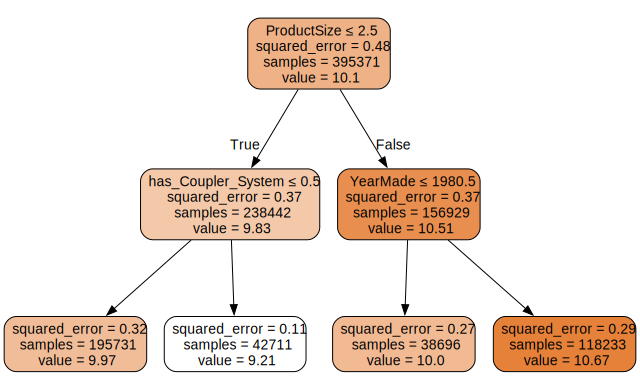

In [54]:
draw_tree(model, Xs, size=10)

Nút ở trên cùng đại diện cho mô hình ban đầu, chưa có phân chia nào cả, toàn bộ dữ liệu nằm trong một nhóm với kích thước là 395371, tức là toàn bộ tập dữ liệu. Ở bước này, mô hình chưa làm gì cả và luôn dự đoán giá trị là trung bình của toàn bộ tập dữ liệu, với sai số bình phương trung bình (mean squared error) là 0.48.

Khi đi xuống nhánh bên trái, đó là các bản ghi có `ProductSize` nhỏ hơn 2.5, còn nhánh bên phải là các bản ghi có `ProductSize` lớn hơn hoặc bằng 2.5, và cứ tiếp tục như vậy.

Bạn có thể thấy thuật toán cây quyết định (decision tree) của chúng ta đã tìm được cách chia nhị phân duy nhất để tách biệt các giá trị cao và thấp của giá đấu (auction price). Nút bên trái có `SalePrice` thấp hơn so với nút bên phải.

Dưới đây là một cách khác để biểu diễn cây của chúng ta.

/home/monarch/workplace/bb_bulldozer/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


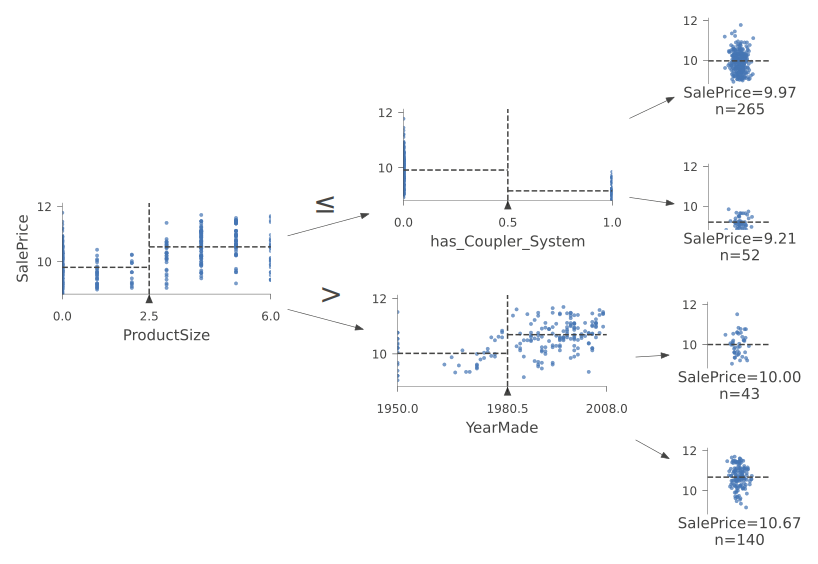

In [69]:
samp_idx = np.random.permutation(len(y))[:500]
viz_model = dtreeviz.model(model, X_train=Xs.iloc[samp_idx], y_train=y.iloc[samp_idx],
                           feature_names=Xs.columns, target_name=dep_var, )
viz_model.view(scale=2, fontname='DejaVu Sans', label_fontsize=10, orientation='LR')

biều đồ này cho chúng ta thấy được sự phân bổ của dữ liệu tại mỗi điềm chia

In [83]:
def m_rmse(xs, y, m=model): return rmse(m.predict(xs), y)

In [84]:
model = DecisionTreeRegressor(min_samples_leaf=25)
model.fit(Xs, y)
m_rmse(Xs, y), m_rmse(val_Xs, val_y)

(0.2122652389082077, 0.2771294174783668)

In [85]:
model.get_n_leaves()

np.int64(12063)